## Recurrent Neural Networks - Text Classification

#### Hemant Thapa

The primary objective of our project was to create a model capable of effectively categorizing text data into predefined classes. With a dataset comprising 20,000 training samples and 6,709 testing samples, we aimed to build a solution that could not only handle the scale of the data but also deliver accurate and reliable results.

Our chosen architecture is a sequential framework, well-known for its effectiveness in NLP tasks, and incorporated Recurrent Neural Networks (RNNs) as a key component. The model's core components included an Embedding layer with 160,000 parameters, engineered to process and represent textual input efficiently. Following this, a GlobalAveragePooling1D layer was incorporated to reduce data dimensionality while preserving critical information. Two Dense layers were employed, with the first layer featuring 24 units and the second a single unit, collectively adding 433 parameters. These dense layers were responsible for interpreting the learned features and making the final prediction.

To prepare the textual data for model training, we employed a Tokenizer class instance with a word limit of 10,000 words and an out-of-vocabulary token ```(<OOV>)```. This tokenizer was fitted to the training sentences, enabling us to convert both training and testing sentences into sequences of integers. To ensure consistent input size for the model, sequences were equalized in length, with a maximum limit of 100 words, using padding and truncation techniques.

##### Importing Libraries 

In [1]:
import io
import json
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##### Loading Json dataset 

In [3]:
def load_json_dataset(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        datastore = json.loads(response.text)
    
        sentences = []
        labels = []
    
        for item in datastore:
            sentences.append(item['headline'])
            labels.append(item['is_sarcastic'])
        
        return datastore, sentences, labels
    else:
        print(f"Failed to fetch data from URL. Status code: {response.status_code}")
        return None, None, None

In [4]:
datastore, sentences, labels = load_json_dataset("https://storage.googleapis.com/learning-datasets/sarcasm.json")

In [5]:
datastore[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [6]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [7]:
labels[:10]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

##### Exporting Json file to text format 

In [8]:
if datastore:
    print(f"Loaded {len(sentences)} sentences and {len(labels)} labels.")
    #save datastore to a text file
    with open("datastore.txt", "w") as outfile:
        json.dump(datastore, outfile)
else:
    print("Data loading failed.")

Loaded 26709 sentences and 26709 labels.


##### Feature Engineering - Train and Test Size 

In [9]:
training_size = 20000

In [10]:
print(f"Training size of data : {training_size}")
print(f"Testing size of data : {len(sentences) - training_size}")

Training size of data : 20000
Testing size of data : 6709


In [11]:
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]

In [12]:
testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [13]:
#an object of tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

In [14]:
#fitting model
tokenizer.fit_on_texts(training_sentences)

In [15]:
#word index
word_index = tokenizer.word_index

In [16]:
#text to sequences 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

In [17]:
#padding 
training_padded = pad_sequences(training_sequences, maxlen=100, padding='post', truncating='post')
testing_padded = pad_sequences(testing_sequences, maxlen=100, padding='post', truncating='post')

In [18]:
#comverting to numpy array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

##### Selecting Model 

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 162385 (634.32 KB)
Trainable params: 162385 (634.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
625/625 - 17s - loss: 0.6874 - accuracy: 0.5540 - val_loss: 0.6915 - val_accuracy: 0.5633 - 17s/epoch - 27ms/step
Epoch 2/50
625/625 - 15s - loss: 0.6401 - accuracy: 0.6405 - val_loss: 0.6114 - val_accuracy: 0.6976 - 15s/epoch - 23ms/step
Epoch 3/50
625/625 - 13s - loss: 0.4877 - accuracy: 0.7792 - val_loss: 0.5531 - val_accuracy: 0.7441 - 13s/epoch - 21ms/step
Epoch 4/50
625/625 - 11s - loss: 0.4163 - accuracy: 0.8252 - val_loss: 0.5777 - val_accuracy: 0.7409 - 11s/epoch - 18ms/step
Epoch 5/50
625/625 - 13s - loss: 0.3331 - accuracy: 0.8716 - val_loss: 0.5736 - val_accuracy: 0.7640 - 13s/epoch - 21ms/step
Epoch 6/50
625/625 - 14s - loss: 0.2813 - accuracy: 0.8945 - val_loss: 0.6204 - val_accuracy: 0.7441 - 14s/epoch - 23ms/step
Epoch 7/50
625/625 - 11s - loss: 0.2415 - accuracy: 0.9127 - val_loss: 0.6463 - val_accuracy: 0.7511 - 11s/epoch - 18ms/step
Epoch 8/50
625/625 - 12s - loss: 0.2110 - accuracy: 0.9246 - val_loss: 0.6720 - val_accuracy: 0.7532 - 12s/epoch - 19ms/step


##### Loss and Accuracy plot 

In [23]:
def plot_graphs(history, string, title=None, xlabel="Epochs", ylabel=None):
    plt.figure(figsize=(6, 5))
    epochs = range(1, len(history.history[string]) + 1)
    train_values = history.history[string]
    val_values = history.history['val_' + string]

    plt.plot(epochs, train_values, linestyle='-', color='blue', label='Training ' + string)
    plt.plot(epochs, val_values, linestyle='-', color='green', label='Validation ' + string)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend()
    plt.grid(True, linestyle='--', color='black', alpha=0.2)
    plt.show()

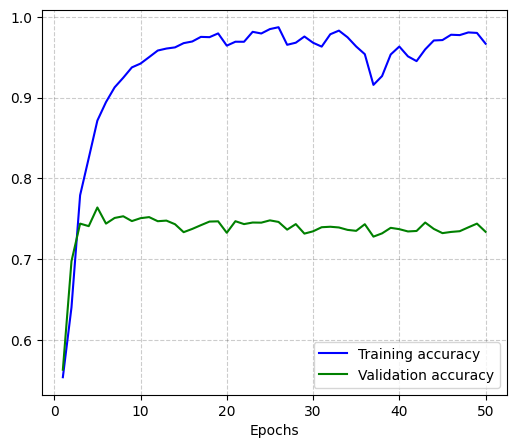

In [24]:
plot_graphs(history, "accuracy")

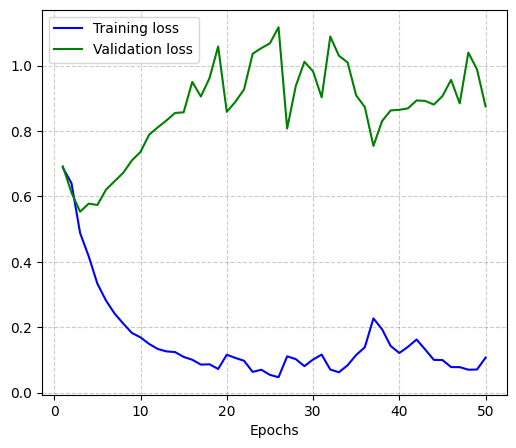

In [25]:
plot_graphs(history, "loss")

In [26]:
#inversing word index
reverse_word_index = {}
for key, value in word_index.items():
    reverse_word_index[value] = key

In [27]:
#decoding sentence
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [28]:
print(decode_sentence(training_padded[0]))

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [29]:
print(training_sentences[2])

mom starting to fear son's web series closest thing she will have to grandchild


In [30]:
print(labels[2])

1


In [31]:
#vocab_size, embedding_dim
e = model.layers[0]
weights = e.get_weights()[0]

In [32]:
print(weights.shape) 

(10000, 16)


In [33]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [34]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

In [35]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [36]:
predictions = model.predict(padded)

1/1 [==============================] - 0s 447ms/step


In [37]:
np.set_printoptions(suppress=True)

In [38]:
print(predictions)

[[0.03308396]
 [0.05850819]]


Close to 1 : High probability of sarcasm

Close to 0 : Low probability of sarcasm 

In [39]:
def text_classification_test(string):
    temp_sequences = tokenizer.texts_to_sequences([string])
    temp_padded = pad_sequences(temp_sequences, maxlen=100, padding='post', truncating='post')
    temp_predictions = model.predict(temp_padded)
    #model returns a single prediction value
    sentiment_score = temp_predictions[0]  
    classification = ""

    if sentiment_score < -0.4:
        classification = "Very Bad"
    elif sentiment_score < 0:
        classification = "Bad"
    elif sentiment_score < 0.5:
        classification = "Not Bad"
    else:
        classification = "Good"

    print(f"Text: {string}")
    print(f"Sentiment Score: {sentiment_score}")
    print(f"Classification: {classification}")

In [40]:
text_classification_test("Oh, great! Another Monday to look forward to")

1/1 [==============================] - 0s 39ms/step
Text: Oh, great! Another Monday to look forward to
Sentiment Score: [0.98063445]
Classification: Good


In [41]:
text_classification_test("Wow, my day couldn't get any better! Another flat tire on my way to work in this pouring rain.")

1/1 [==============================] - 0s 47ms/step
Text: Wow, my day couldn't get any better! Another flat tire on my way to work in this pouring rain.
Sentiment Score: [0.00615104]
Classification: Not Bad


In [42]:
text_classification_test("I'm absolutely thrilled to be stuck in traffic for hours on a Friday evening.")

1/1 [==============================] - 0s 46ms/step
Text: I'm absolutely thrilled to be stuck in traffic for hours on a Friday evening.
Sentiment Score: [0.72016823]
Classification: Good


In [43]:
text_classification_test("I just won the lottery, and now I have to pay taxes on it! Life is so unfair.")

1/1 [==============================] - 0s 49ms/step
Text: I just won the lottery, and now I have to pay taxes on it! Life is so unfair.
Sentiment Score: [0.02369536]
Classification: Not Bad


**References:**

**Book:**

- *Sculpting Data for ML: The First Act of Machine Learning*
  - Authors: Jigyasa Grover, Rishabh Misra
  - Publisher: Jigyasa Grover & Rishabh Misra
  - Year: 2021
  - ISBN: 9798585463570
  - Page Count: 158
  - Language: English
  - Contributors: Julian McAuley, Laurence Moroney, Mengting Wan
ting Wan
